# Fastai Tabular

- Fastai: Deep learning library built on top of PyTorch (PyTorch = NumPy for GPUs)
- High-level abstractions and easy-to-use
- **Fastai tabular: Module specifically designed for tabular data**

Fastai is the master of doing more in less lines. Here is the **code which loads + preprocesses data and trains a neural net**:

```python
from fastai.tabular.all import *

# Load data
dls = TabularDataLoaders.from_csv('sample_data/titanic.csv',
                                  y_names=['Survived'],
                                  y_block = CategoryBlock,
                                  cat_names=['Pclass', 'Sex', 'Embarked'],
                                  cont_names=['Age', 'Fare', 'SibSp'],
                                  procs=[Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=[accuracy])
# Train model
learn.fit_one_cycle(5)
 # Evaluate model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
```

Lets take it apart!

## 0. Downloading the dataset
In this notebook we will use the Titanic dataset, which can be downloaded at: https://github.com/datasciencedojo/datasets/blob/master/titanic.csv

To add the .csv to a Colab notebook, you have to
- Click on the Folder icon on the top left of your screen
- Drag & Drop the .csv into the "sample_data" folder which popped up on the left

**Warning:** If you **reconnect** to the notebook you have to **repeat this step**!

If it worked, we can load the data:

In [ ]:
import pandas as pd

df = pd.read_csv('sample_data/titanic.csv')
df.head()

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                    Name     Sex   Age  SibSp  \
0                                Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Thayer)  female  38.0      1   
2                                 Heikkinen, Miss. Laina  female  26.0      0   
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                               Allen, Mr. William Henry    male  35.0      0   
..                                                   ... 

The task commonly associated with this dataset is: **Predict survival based on remaining columns!**

## 1. Load Data

Fastai's `TabularDataLoaders` class takes care of loading and preprocessing the data. Lets apply it to the Titanic dataset!

With `y_names` we can specify which **columns** should be **predicted** and `y_block` indicates if it contains categorical `CategoryBlock` or continuous values `RegressionBlock`:

```python
from fastai.tabular.all import *

# Load data
dls = TabularDataLoaders.from_csv('sample_data/titanic.csv',
                                  y_names=['Survived'],
                                  y_block = CategoryBlock)
```

```
TypeError: can't convert np.ndarray of type numpy.object_.
```
The above code snipped results in an error, because some important preprocessing steps are missing!

The `TabularDataLoaders` class can handle three **often necessary preprocessing steps**:
 - `FillMissing`: Fill missing values
 - `Categorify`: Convert strings (e.g. 'male', 'female') into classes (e.g. 0, 1)  
 - `Normalize`: Normalize continuous variables

To apply these preprocessing steps, we first have to define categorical `cat_names` and continuous feature columns `cont_names`:

```python
from fastai.tabular.all import *

# Load data
dls = TabularDataLoaders.from_csv('sample_data/titanic.csv',
                                  y_names=['Survived'],
                                  y_block = CategoryBlock,
                                  cat_names=['Pclass', 'Sex', 'Embarked'],
                                  cont_names=['Age', 'Fare', 'SibSp', 'Parch'])
```
Given `cat_names` and `cont_names`, preprocessing steps can be specified using the `procs` argument:

```python
from fastai.tabular.all import *

# Load data
dls = TabularDataLoaders.from_csv('sample_data/titanic.csv',
                                  y_names=['Survived'],
                                  y_block = CategoryBlock,
                                  cat_names=['Pclass', 'Sex', 'Embarked'],
                                  cont_names=['Age', 'Fare', 'SibSp', 'Parch'],
                                  procs=[Categorify, FillMissing, Normalize])
```
Lets run it!

In [ ]:
from fastai.tabular.all import *

# Load data
dls = TabularDataLoaders.from_csv('sample_data/titanic.csv',
                                  y_names=['Survived'],
                                  y_block = CategoryBlock,
                                  cat_names=['Pclass', 'Sex', 'Embarked'],
                                  cont_names=['Age', 'Fare', 'SibSp', 'Parch'],
                                  procs=[Categorify, FillMissing, Normalize])

### 1.1 Data checking via "show_batch"

Finally, the code snippet does not result in an error!

But what has the `TabularDataLoaders` done to the data? **To check that it did not screw up the data, we should have a look!**

Using  `dls.show_batch()` the loaded data can be visually checked.

In [ ]:
dls.show_batch()

,Pclass,Sex,Embarked,Age_na,Age,Fare,SibSp,Survived
0,1,male,C,False,46.000001,7.920000e+01,-7.842571e-09,0
1,3,male,S,False,28.000000,7.895801e+00,-7.842571e-09,0
2,1,male,C,False,40.000000,2.772080e+01,-7.842571e-09,0
3,3,male,S,True,28.500000,7.895801e+00,-7.842571e-09,0
4,3,male,S,False,19.000000,5.798495e-07,-7.842571e-09,0
5,3,male,S,False,18.000000,6.495800e+00,1.000000e+00,0
6,3,male,S,False,43.000001,6.449999e+00,-7.842571e-09,0
7,2,female,S,False,30.000000,2.100000e+01,3.000000e+00,1
8,3,male,S,False,42.000000,7.550000e+00,-7.842571e-09,0
9,3,male,S,True,28.500000,8.050001e+00,-7.842571e-09,0


**Task:** What changed in the data when you compare it to the original .csv file?

- Deleted Columns: "PassangerId", "Name", "Ticket" and "Cabin" (not in `cat_names` or `cont_names`)
- Added Column: "Age_na" (if `FillMissing`)
- Order: `cat_names`, `cont_names`, `y_names`
- Still strings in it, continuous not normalized?!

`dls.procs` returns a summary of all the changes which the DataLoaders apply to the orginal data:

In [ ]:
dls.procs

Pipeline: FillMissing -- {'fill_strategy': <function FillStrategy.median at 0x7fdcefd383a0>, 'add_col': True, 'fill_vals': defaultdict(<class 'int'>, {'Age': 0}), 'na_dict': {'Age': 28.5}} -> Categorify -- {'classes': {'Pclass': ['#na#', 1, 2, 3], 'Sex': ['#na#', 'female', 'male'], 'Embarked': ['#na#', 'C', 'Q', 'S'], 'Age_na': ['#na#', False, True]}} -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False} -> Normalize -- {'mean': None, 'std': None, 'axes': (0, 2, 3), 'means': {'Age': 29.703842163085938, 'Fare': 32.45029067993164, 'SibSp': 0.5343618513323983}, 'stds': {'Age': 13.011497597558593, 'Fare': 51.24542246328125, 'SibSp': 1.1466203146959768}}

`dls.one_batch` loads and returns one batch:

In [ ]:
dls.one_batch()


## 2. Model training

Once the data is loaded, we create a Learner (trainable Object) `learn` which contains the DataLoader `dls` and the PyTorch model `model`. (For arbitrary data modalities, we would do `learn = Learner(dls, model)`)

Fastai tabular offers the `tabular_learner` which automatically creates a PyTorch model for tabular data.

```python
learn = tabular_learner(dls)

# Train the model
learn.fit_one_cycle(5)
```

Using `fit_one_cycle` method the model is trained for 5 epochs - i.e. after training it has "seen" each data point 5 times.

### 2.1 PyTorch model (being curious 🤓)
Lets first have a short look at the model created by `tabular_learner`

```python
learn = tabular_learner(dls)
print(learn.model)
```

```
TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(3, 3)
    (2): Embedding(4, 3)
    (3): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=15, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)
```

This is how a neural net looks like in PyTorch!

The lines
```
...
(0): Linear(in_features=15, out_features=200, bias=False)
...
(0): Linear(in_features=200, out_features=100, bias=False)
...
(0): Linear(in_features=100, out_features=2, bias=False)
...
```
specify the architecture of the neural network:
- two hidden layers with 200 and 100 nodes (see `out_features`)
- a final layer with 2 nodes - i.e. "Survived" and "Not Survived" node

**Task**: Google/ChatGPT what ReLU and BatchNorm does. Explain in bullet points!


- ReLU: All negative values become 0 -> max(0, x)
- BatchNorm: Normalize + gamma * x_normalized + beta

### 2.2 Training

Lets run the analysis!


In [ ]:
from fastai.tabular.all import *

# Load data
dls = TabularDataLoaders.from_csv('sample_data/titanic.csv',
                                  y_names=['Survived'],
                                  y_block = CategoryBlock,
                                  cat_names=['Pclass', 'Sex', 'Embarked'],
                                  cont_names=['Age', 'Fare', 'SibSp', 'Parch'],
                                  procs=[Categorify, FillMissing, Normalize])

learn = tabular_learner(dls)
# Train model
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.727326,0.647645,00:00
1,0.667965,0.619180,00:00
2,0.633925,0.600873,00:00
3,0.605119,0.572053,00:00
4,0.581557,0.560964,00:00


Ok, what are we looking at?
- First column `epoch`: Epochs count starting with epoch 0 (Python indexing)
- Second column `train_loss`: Training loss - Model performance (at epoch end) in training data
- Third column `valid_loss`: Validation loss - Model performance (at epoch end) in validation data
- Fourth column `time`: Runtime for each epoch

Two things that we need to understand
- What is a loss?
- Why is there a `train_loss` AND a `valid_loss`?

#### 2.2.1 Loss function

Loss functions measure the dissimilarity between predicted $\hat{y}$ and actual $y$ targets and are directly used for optimization.

**Don't Panic:** You do not have to understand the following two formulars!

For regression, the mean squared error

$MSE = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$

is commonly used.

The analog loss function for classification is the Cross-Entropy

$CE = -\frac{1}{N} \sum_{i=1}^{N} \left(y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)\right)$ .

The important facts are:
- **Larger MSE/CE -> Worse predictions**
- MSE/CE = 0 -> Predicted and actual targets are the same
- **MSE and CE are the standard loss functions** for classification/regression

Using `learn.loss_func` we can find out what loss function our Learner used:

In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Nice, `tabular_learner` per default uses CrossEntropyLoss for categorical targets!

#### 2.2.2 Train-Validation Split
The logging shows two losses - i.e. `train_loss` and `valid_loss` - because the `DataLoaders` in fastai automatically split the data into two parts:
- **Training data**: **Data the model "sees"** and tries to emulate during training (~80% of total data)
- **Validation data**: **Data unseen by the model** -> "Real" model performance (~20% of total data)

Lets fit a model for 100 epochs and look at the losses over time:

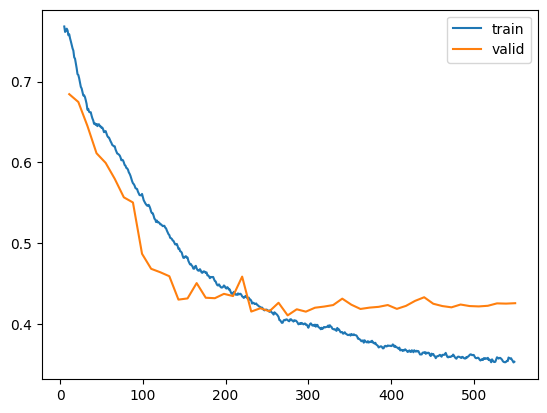

In [ ]:
from fastai.tabular.all import *

# Load data
dls = TabularDataLoaders.from_csv('sample_data/titanic.csv',
                                  y_names=['Survived'],
                                  y_block = CategoryBlock,
                                  cat_names=['Pclass', 'Sex', 'Embarked'],
                                  cont_names=['Age', 'Fare', 'SibSp'],
                                  procs=[Categorify, FillMissing, Normalize])

learn = tabular_learner(dls)
# Train model without logging
with learn.no_bar() and learn.no_logging():
  learn.fit_one_cycle(50)

learn.recorder.plot_loss()

Now we can easily see why we needed to split the data!

`train_loss` keeps improving while `valid_loss` stops after ~25 epochs -> **model overfits to useless patterns in the training data**.

Hyperparameter optimization: ~25 epochs would be a good training duration here!

#### 2.2.3 Metrics

It makes sense to monitor additional metrics besides loss during model training.

For classification, accuracy - i.e. proportion of correct predicitons - is one of the most used metrics. We can add it during the creation of the Learner

```python
learn = tabular_learner(dls, metrics=[accuracy])
```
Lets run training with the accuracy metric:

In [ ]:
from fastai.tabular.all import *

# Load data
dls = TabularDataLoaders.from_csv('sample_data/titanic.csv',
                                  y_names=['Survived'],
                                  y_block = CategoryBlock,
                                  cat_names=['Pclass', 'Sex', 'Embarked'],
                                  cont_names=['Age', 'Fare', 'SibSp'],
                                  procs=[Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=[accuracy])
# Train model
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.675704,0.696340,0.415730,00:00
1,0.630998,0.671033,0.668539,00:00
2,0.600962,0.678218,0.730337,00:00
3,0.578453,0.650922,0.730337,00:00
4,0.555416,0.626991,0.758427,00:00


Nice, we have a **metric** which is much more **human understandable** than cross-entropy!

Per default, **metrics are only calculated in the validation data** -> If users optimize training hyperparameters (e.g. epochs) based on metrics, they do not overfit the model to the training data!

**Task:** Write a function which measures the opposite of the accuracy - i.e. proportion of wrong predictions - and run training with it instead of `accuracy`!

In [ ]:
def error_rate(y_targ, y_pred):
  return 1 - accuracy(y_targ, y_pred)

from fastai.tabular.all import *

# Load data
dls = TabularDataLoaders.from_csv('sample_data/titanic.csv',
                                  y_names=['Survived'],
                                  y_block = CategoryBlock,
                                  cat_names=['Pclass', 'Sex', 'Embarked'],
                                  cont_names=['Age', 'Fare', 'SibSp'],
                                  procs=[Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=[accuracy, error_rate_tushar])
# Train model
learn.fit_one_cycle(5)


## 3. Evaluation

After model training is optimized and finished, we can use the `ClassificationInterpretation` class to visualize the results

```python
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
```

The confusion matrix is a detailed visualization for class predictions:


epoch,train_loss,valid_loss,accuracy,time
0,0.782398,0.669497,0.713483,00:00
1,0.701465,0.638381,0.724719,00:00
2,0.652461,0.615692,0.719101,00:00
3,0.617347,0.604284,0.707865,00:00
4,0.596622,0.601114,0.713483,00:00


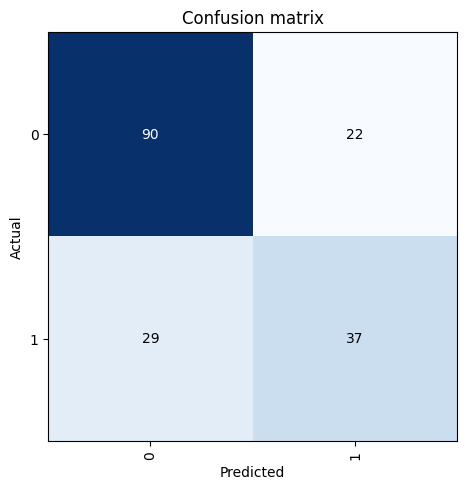

In [ ]:
from fastai.tabular.all import *

# Load data
dls = TabularDataLoaders.from_csv('sample_data/titanic.csv',
                                  y_names=['Survived'],
                                  y_block = CategoryBlock,
                                  cat_names=['Pclass', 'Sex', 'Embarked'],
                                  cont_names=['Age', 'Fare', 'SibSp'],
                                  procs=[Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=[accuracy])
# Train model
learn.fit_one_cycle(5)

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**Task 3.1:** Calculate model accuracy based on the numbers in the confusion matrix.

Accuracy = (90 + 37) / (90 + 22 + 29 + 37) = 178 = 0.713 = 71.3%

**Task 3.2:** Calculate model precision and recall based on the numbers in the confusion matrix.

Precision = 37 / (22 + 37) = 0.627 = 62.7%
Recall = 37 / (29 + 37) = 0.561 = 56.1%

**Task 3.3:** Can you imagine a prediction task where you want to optimize for precision/recall instead of accuracy?

Optimize Precision: Fraud Detection
Optimize Recall: Medical Diagnosis

**Task 3.4:** What is balanced accuracy?

Balanced accuracy = (Precision + Recall) / 2 = 0.594 = 59.4%


## Exercise 1
Load and preprocess the California Housing dataset (sample_data/california_housing_test.csv) and train a neural net to predict the median income!


## Exercise 2
Squeeze more information out of the Titanic dataset! Extract the title (e.g. "Miss.") based on the "Name" column and repeat the analysis using your newly created "Title" column.